# Quantum Time Series Analysis: Serial Model
Compatible with Qiskit 1.02+

### Author
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Date
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022
- May 2024: Compatibility upgrade to Qiskit 1.02 

### Aims
> *This script aims to create a single qubit serial variational model to fit some data and provide a forecast.*

### Note
> *<font color="tomato">When running this script, you are likely to obtain slightly different results each time.</font>*

### Primary Sources
- Schuld, Maria, Ryan Sweke, and Johannes Jakob Meyer. 
    "The Effect of Data Encoding on the Expressive Power of Variational Quantum Machine Learning Models." 
    *Physical Review A 103*, no. 3 (March 24, 2021): 032430.<br/> 
    http://arxiv.org/abs/2008.08605<br/>
- PennyLane Dev Team. "Quantum models as Fourier series", Last updated: 15 Jan 2021.<br/>
    https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series.html

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/qiskit-gpu/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/site-packages',
 '.']

In [2]:
import os
import numpy as np
import pylab
import math
import json
import time
from tqdm.notebook import tqdm

from IPython.display import clear_output

from utils.Target import *
from utils.Charts import *
from utils.Files import *
from utils.Cost import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
### Libraries used in QAE development

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, NELDER_MEAD, SPSA, ADAM, L_BFGS_B
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.utils.loss_functions import L1Loss, L2Loss
from qiskit.circuit import Parameter

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

In [4]:
### Listing control
debug = True

### Software version
MAJOR = 9
MINOR = 0

### Constants
LOG_NAME = 'log_2'
CASE_NAME = 'serial'
DATA_NAME = '2_sins'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_2',
 'serial',
 '2_sins',
 'log_2/data',
 'log_2/training',
 'log_2/params',
 'log_2/analysis',
 'log_2/figures')

## Fetch data

In [5]:
### All created files have the following codes:
DATA_ID = '2_sins_t50_v20_z0.0_w0_s0_h0'

### Define file names

x_all_fpath = f'{DATA_PATH}/{DATA_ID}/x_all.arr'
y_all_fpath = f'{DATA_PATH}/{DATA_ID}/y_all.arr'

x_train_fpath = f'{DATA_PATH}/{DATA_ID}/x_train.arr'
y_train_fpath = f'{DATA_PATH}/{DATA_ID}/y_train.arr'
x_valid_fpath = f'{DATA_PATH}/{DATA_ID}/x_valid.arr'
y_valid_fpath = f'{DATA_PATH}/{DATA_ID}/y_valid.arr'

data_info_fpath = f'{DATA_PATH}/{DATA_ID}/info.json'
data_info_fpath

'log_2/data/2_sins_t50_v20_z0.0_w0_s0_h0/info.json'

In [6]:
### Load the info file
data_info = read_json_file(data_info_fpath)
    
### Get info details
DATA_NAME = data_info['data_name']
DATA_MAJOR = data_info['major_version'] 
DATA_MINOR = data_info['minor_version']
samples_train = data_info['data_train']
samples_valid = data_info['data_valid']
noise = data_info['data_noise']
wind_size = data_info['wind_size']
wind_step = data_info['wind_step']
horizon = data_info['wind_horizon']
seed = data_info['seed']
samples = samples_train + samples_valid
train_pc = samples_train / samples

print(f'\nSaved time series info in file "{data_info_fpath}":\n')
for k in data_info.keys():
    print(f'\tinfo[{k}] = {data_info[k]}')
print()
print(f'\tcalc[samples] = {samples}')
print(f'\tcalc[train_pc] = {train_pc}')
print()


Saved time series info in file "log_2/data/2_sins_t50_v20_z0.0_w0_s0_h0/info.json":

	info[data_name] = 2_sins
	info[major_version] = 8
	info[minor_version] = 10
	info[data_train] = 50
	info[data_valid] = 20
	info[data_noise] = 0.0
	info[wind_size] = 0
	info[wind_step] = 0
	info[wind_horizon] = 0
	info[seed] = 1770

	calc[samples] = 70
	calc[train_pc] = 0.7142857142857143



In [7]:
### Load data files
X_all = read_ts_file(x_all_fpath)[..., None]
y_all = read_ts_file(y_all_fpath)
X_train = read_ts_file(x_train_fpath)[..., None]
y_train = read_ts_file(y_train_fpath)
X_valid = read_ts_file(x_valid_fpath)[..., None]
y_valid = read_ts_file(y_valid_fpath)
print(f'\nLoaded time series data\n')


Loaded time series data



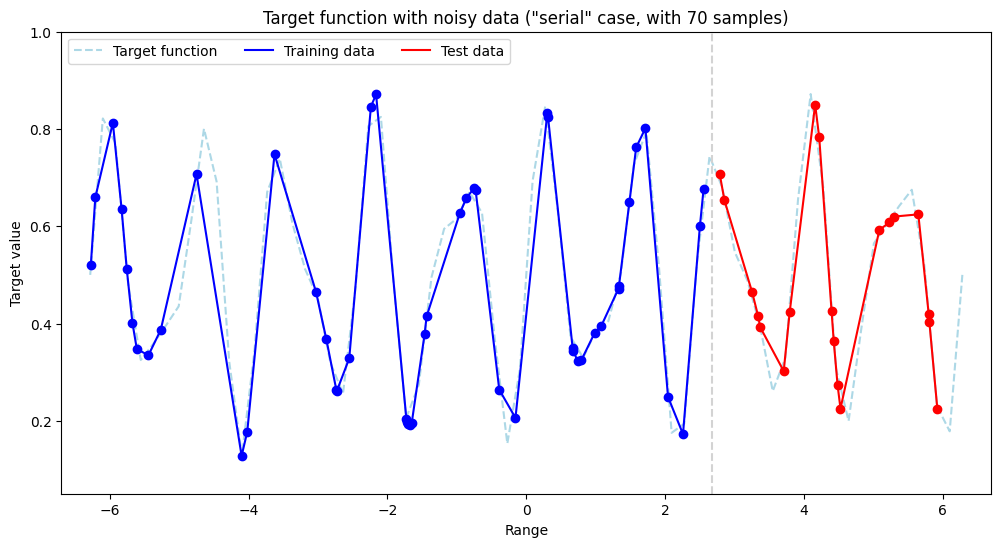

In [8]:
##### Plot data
plot_train_and_test_data(
    X_all, y_all, X_train, y_train, X_valid, y_valid,
    xlim=(-6.7, 6.7), ylim=(0.05, 1),
    colors=['lightblue', 'blue', 'red', 'blue', 'red'], linestyles=['dashed', 'solid', 'solid'],
    title=f'Target function with noisy data ("{CASE_NAME}" case, with {samples} samples)'
)

## Create a serial model to fit data

### Identify device

In [9]:
### Find what devices are available
from qiskit_aer import Aer
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
print(f'Available quantum devices: {devices}')

### Priority GPU
device = 'GPU' if ('GPU' in devices) else 'CPU'

### Force CPU for this run
device = 'CPU'
device
print(f'Selected device: {device}')

Available quantum devices: ('CPU', 'GPU')
Selected device: CPU


In [10]:
### Create a sampler/estimator suitable for the device
#   GPU methods: statevector, tensor_network, density_matrix, unitary

from qiskit.primitives import Sampler, Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Sampler as AerSampler, Estimator as AerEstimator # For device="GPU" option

seed = 2022
shots = 10000

if device == 'GPU':
    sampler = AerSampler(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
    
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
else:
    sampler = Sampler()
    estimator = Estimator()

### Create a serial model and test it

ParameterView([Parameter(W[000]), Parameter(W[001]), Parameter(W[002]), Parameter(W[003]), Parameter(W[004]), Parameter(W[005]), Parameter(W[006]), Parameter(W[007]), Parameter(W[008]), Parameter(W[009]), Parameter(W[010]), Parameter(W[011]), Parameter(W[012]), Parameter(W[013]), Parameter(W[014]), Parameter(W[015]), Parameter(W[016]), Parameter(W[017]), Parameter(X)])



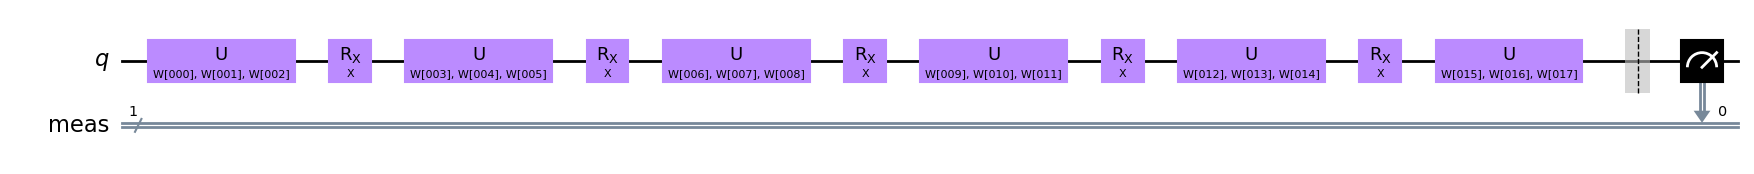

In [11]:
### Create a custom serial model circuit 
#   - To be used with CircuitQNN / NeuralNetworkRegressor

def serial_fourier_model(layers, add_meas=False):
    
    ansatz = QuantumCircuit(1, name="ansatz")
    param_x = Parameter('X')
    pno = 0 # Variational parameter counter
    params = []

    # Data encoding block
    def S():
        ansatz.rx(param_x, 0)

    # Trainable variational block
    def W(layer, label):
        nonlocal pno
        nonlocal params
        param_w_0 = Parameter(f'{label}[{pno:03d}]')
        param_w_1 = Parameter(f'{label}[{pno+1:03d}]')
        param_w_2 = Parameter(f'{label}[{pno+2:03d}]')
        params += [param_w_0, param_w_1, param_w_2]
        ansatz.u(param_w_0, param_w_1, param_w_2, 0)
        pno += 3

    # Create layers of W, S blocks
    for l in range(layers):
        W(l, 'W')
        S()

    # Add the final block
    W(layers, 'W')

    if add_meas:
        ansatz.measure_all()

    # Create a parameter list
    params += [param_x]

    return ansatz 

# Show a sample serial model with the specified number of layers
m = serial_fourier_model(5, add_meas=True)

# Show all parameters, the last is X
print(m.parameters)
print()

# Show the circuit
m.draw(output='mpl', style='clifford', scale=1, fold=True);

### Construct and train a model

In [12]:
# Define model, its parameters and their initial values (including random input)
epochs = 40 # 1000
log_interval = 1 # 10
prompt_interval = 1 # 50 # 100
layers = 27 # 3 # 9 # 15 # 21 # 27 # 33
model = serial_fourier_model(layers)
init_weights = 2 * np.pi * algorithm_globals.random.random((layers+1)*3)

In [13]:
### Define a regressor

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

obs = SparsePauliOp.from_list([("Z" * model.num_qubits, 1)]) 
regr_qnn = EstimatorQNN(
    circuit=model,
    input_params=[model.parameters[-1]],
    weight_params=model.parameters[:-1],
    observables=obs,
    estimator=estimator
)

# Recommended optimizers and their parameters:  
#   COBYLA() # COBYLA(maxiter=300) # COBYLA(maxiter=500)
#   NELDER_MEAD() # NELDER_MEAD(maxiter=100) # NELDER_MEAD(maxiter=500)
#   L_BFGS_B() # L_BFGS_B(maxiter=10) # L_BFGS_B(maxiter=16)
# Not recommended: 
#   ADAM(maxiter=100) - slow/no callbacks
#   UMDA(maxiter=200) - slow/incorrect callbacks

loss_fun = L2Loss()
loss_fun_name = 'L2Loss'

optimizer = L_BFGS_B(maxiter=epochs) # COBYLA(maxiter=epochs) # 
progress_bar = tqdm(total=epochs, desc='QNN training epoch: ')
regr_callback = Regr_callback(log_interval=log_interval, prompt_interval=prompt_interval, tqdm_progress=progress_bar)

regressor = NeuralNetworkRegressor(
    neural_network=regr_qnn,
    loss=loss_fun,
    optimizer=optimizer, 
    initial_point=init_weights, 
    callback=regr_callback.objfun_print
)

QNN training epoch:   0%|          | 0/40 [00:00<?, ?it/s]

In [14]:
### Train the model

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Fit to data and plot progress
print(f'\nOptimum model calculation\n')

regr_callback.reset()
start = time.time()
regressor.fit(X_train, y_train) 
elapsed = time.time() - start

### Find the optimum objective fun value and NN weights
min_obj = regr_callback.min_obj()
print(f'\nOptimum objective value: {np.round(min_obj[1], 4)} @ {min_obj[0]*log_interval} (time={np.round(elapsed, 0)} secs)\n')


Optimum model calculation

Results:   epoch=    1, min cost / real=0.65850 / logged=0.65850   @     0
Results:   epoch=    2, min cost / real=0.65850 / logged=0.65850   @     0
Results:   epoch=    3, min cost / real=0.25870 / logged=0.25870   @     2
Results:   epoch=    4, min cost / real=0.25870 / logged=0.25870   @     2
Results:   epoch=    5, min cost / real=0.25870 / logged=0.25870   @     2
Results:   epoch=    6, min cost / real=0.14550 / logged=0.14550   @     5
Results:   epoch=    7, min cost / real=0.12990 / logged=0.12990   @     6
Results:   epoch=    8, min cost / real=0.07690 / logged=0.07690   @     7
Results:   epoch=    9, min cost / real=0.04540 / logged=0.04540   @     8
Results:   epoch=   10, min cost / real=0.03970 / logged=0.03970   @     9
Results:   epoch=   11, min cost / real=0.02170 / logged=0.02170   @    10
Results:   epoch=   12, min cost / real=0.02170 / logged=0.02170   @    10
Results:   epoch=   13, min cost / real=0.01780 / logged=0.01780   @    

In [15]:
### Collect all training history
params_vals = np.array(regr_callback.params_vals)
objfun_vals = np.array(regr_callback.objfun_vals)
print(f'Param shape: {params_vals.shape}, Obj fun shape={objfun_vals.shape}')

Param shape: (48, 84), Obj fun shape=(48,)


## Save training data

In [16]:
### All created files have the following codes:
#   n: sample size
#   z: level of noise injected
#   q: number of qubits
#   l: number of layers
#   opt_name: name of the optimiser
#   ep: number of "maxiter" epochs
opt_name = optimizer.setting.splitlines()[0][11:]
TRAIN_PREF = f'{CASE_NAME}_n{samples}_z{noise}_q{1}_l{layers}_'+\
             f'{opt_name}_'+\
             f'ep{epochs}'
TRAIN_PREF

'serial_n70_z0.0_q1_l27_L_BFGS_B_ep40'

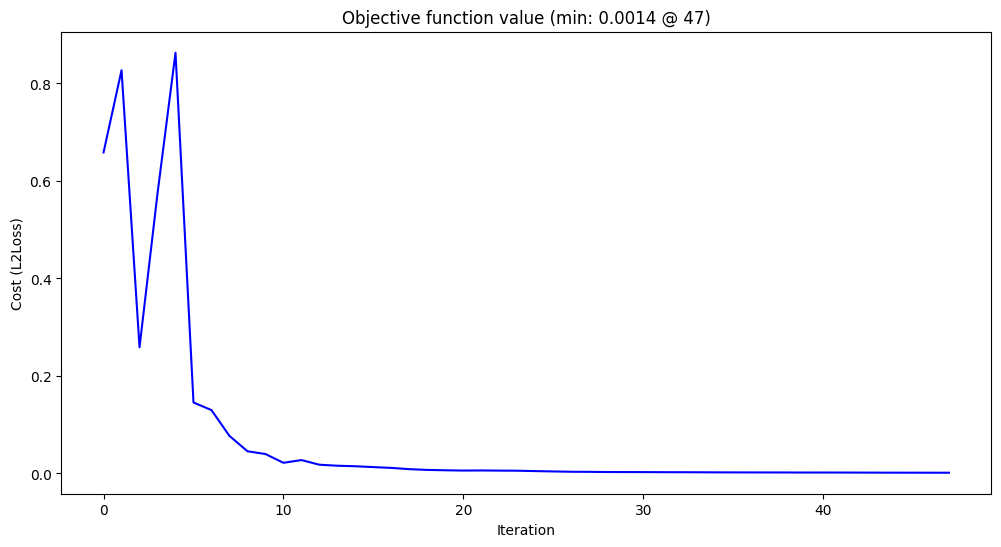

In [17]:
regr_callback.plot(
    ylabel = f'Cost ({loss_fun_name})',
    save_plot = f'{FIGURES_PATH}/train_{TRAIN_PREF}/hist_{loss_fun_name}.eps')

In [18]:
### Training info files 
train_info_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/info.json'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/init.arr'
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/hist.arr'
params_fpath = f'{PARAMS_PATH}/{TRAIN_PREF}/params.arr'
train_info_fpath

'log_2/training/serial_n70_z0.0_q1_l27_L_BFGS_B_ep40/info.json'

In [19]:
## Save training parameters
### Save info details
train_info = \
    {'case_name':CASE_NAME, 
     'major_version':MAJOR, 
     'minor_version':MINOR,
     'data_name':DATA_NAME,
     'data_sample':samples,
     'data_split':train_pc,
     'data_noise':noise,
     'ansatz_qubits':model.num_qubits,
     'ansatz_layers':layers,
     'log_interv':log_interval,
     'opt_name':opt_name,
     'epochs':epochs,
     'shots':shots,
     'seed':seed}

### Saving the info file
write_json_file(train_info_fpath, train_info)
    
print(f'\nSaved time series info in file "{train_info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()


Saved time series info in file "log_2/training/serial_n70_z0.0_q1_l27_L_BFGS_B_ep40/info.json":

	info[case_name] = serial
	info[major_version] = 9
	info[minor_version] = 0
	info[data_name] = 2_sins
	info[data_sample] = 70
	info[data_split] = 0.7142857142857143
	info[data_noise] = 0.0
	info[ansatz_qubits] = 1
	info[ansatz_layers] = 27
	info[log_interv] = 1
	info[opt_name] = L_BFGS_B
	info[epochs] = 40
	info[shots] = 10000
	info[seed] = 2022



In [20]:
### Save the history file
write_ts_file(init_fpath, init_weights)
write_ts_file(history_fpath, objfun_vals)
write_ts_file(params_fpath, params_vals)
print(f'Saved data shapes: init_weights={init_weights.shape}; '+\
      f'objfun_vals=({len(objfun_vals)},); '+\
      f'params_vals=({len(params_vals)}, {len(params_vals[0])})')

Saved data shapes: init_weights=(84,); objfun_vals=(48,); params_vals=(48, 84)


## System details

In [21]:
!pip list | grep -e qiskit -e torch

qiskit                    1.2.4
qiskit-aer-gpu            0.15.1
qiskit-algorithms         0.3.1
qiskit-ibm-runtime        0.32.0
qiskit-machine-learning   0.7.2
qiskit-optimization       0.6.1
